In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.nn import functional 

In [27]:
MAPPING = {
    "acoustic" : 0,
    "blues" : 1,
    "classical" : 2,
    "country" : 3,
    "dance" : 4,
    "edm" : 5,
    "hip-hop" : 6,
    "indie" : 7,
    "jazz" : 8,
    "pop" : 9,
    "rock" : 10,
    "world-music" : 11
}

IMG_FOLDER = "spectrogram"

genres = os.listdir(IMG_FOLDER)
images = np.empty(shape = (1195, 130, 172, 4))
labels = np.empty(1195)

idx = 0
for root, directories, contents in os.walk(IMG_FOLDER):
    if root == IMG_FOLDER: continue
    genre = root.split('/')[1]
    if genre in MAPPING:
        for img_path in contents:
            image = plt.imread(root + "/" + img_path)
            ## Convert to tensor and check the shape
            spec = torch.from_numpy(image)

            ## Move third dimension (color channels) to the first dimension
            spec2 = torch.movedim(spec, source=2, destination=0)

            ## Add an empty first dimension, putting our tensor into the standard format
            spec_final = torch.unsqueeze(spec2, dim=0)
            
            spec_resized = functional.interpolate(spec_final, size = (130,172)) ### 389 /3 = 130 and 515 / 3 = 172
            
            spec_img_format = torch.movedim(spec_resized[0], source=0, destination=2)
            images[idx] = spec_img_format
            labels[idx] = MAPPING[genre]
            idx += 1
            break
    break

In [28]:
## Train-test split
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(images, labels, test_size=0.25, random_state=5)

In [32]:
from torch import nn

'''
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x
'''

class my_net(nn.Module):
    
    ## Constructor commands
    def __init__(self):
        super(my_net, self).__init__()
        
        ## Define architecture
        self.conv_stack = nn.Sequential(
            nn.Conv2d(4,8,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8,16,2,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(20832, 200),
            nn.ReLU(),
            nn.Linear(200, 12)
        )
    
    ## Function to generate predictions
    def forward(self, x):
        scores = self.conv_stack(x)
        return scores

In [39]:
## Hyperparms
epochs = 100
lrate = 0.001
bsize = 10

## For reproduction purposes 
torch.manual_seed(3)

## Cost Function
cost_fn = nn.CrossEntropyLoss()

## Intialize the model
net = my_net()

## Optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(net.parameters(), lr=lrate)

## Make DataLoader
from torch.utils.data import DataLoader, TensorDataset
y_tensor = torch.Tensor(train_y)
X_tensor = torch.from_numpy(train_X)
X_tensor = torch.movedim(X_tensor, source=3, destination=1)
train_loader = DataLoader(TensorDataset(X_tensor.type(torch.FloatTensor), 
                        y_tensor.type(torch.LongTensor)), batch_size=bsize)

In [40]:
## Initial values for cost tracking
track_cost = np.zeros(epochs)
cur_cost = 0.0

## Loop through the data
for epoch in range(epochs):
    
    cur_cost = 0.0
    correct = 0.0
    
    ## train_loader is iterable and numbers knows the batch
    for i, data in enumerate(train_loader, 0):
        
        ## The input tensor and labels tensor for the current batch
        inputs, labels = data
        
        
        ## Clear the gradient from the previous batch
        optimizer.zero_grad()
        
        ## Provide the input tensor into the network to get outputs
        outputs = net(inputs)
        
        ## Calculate the cost for the current batch
        ## nn.Softmax is used because net outputs prediction scores and our cost function expects probabilities and labels
        cost = cost_fn(nn.Softmax(dim=1)(outputs), labels)
        
        ## Calculate the gradient
        cost.backward()
        
        ## Update the model parameters using the gradient
        optimizer.step()
        
        ## Track the current cost (accumulating across batches)
        cur_cost += cost.item()
    
    ## Store the accumulated cost at each epoch
    track_cost[epoch] = cur_cost
    print(f"Epoch: {epoch} Cost: {cur_cost}") ## Uncomment this if you want printed updates

Epoch: 0 Cost: 223.28699445724487
Epoch: 1 Cost: 222.6996500492096
Epoch: 2 Cost: 222.06801581382751
Epoch: 3 Cost: 221.29697585105896
Epoch: 4 Cost: 220.2098605632782
Epoch: 5 Cost: 218.4156801700592
Epoch: 6 Cost: 214.61507511138916
Epoch: 7 Cost: 200.84450125694275
Epoch: 8 Cost: 161.2883620262146
Epoch: 9 Cost: 148.6955682039261
Epoch: 10 Cost: 147.0894558429718
Epoch: 11 Cost: 146.5815669298172
Epoch: 12 Cost: 146.3440318107605
Epoch: 13 Cost: 146.20943439006805
Epoch: 14 Cost: 146.1239094734192
Epoch: 15 Cost: 146.0652596950531
Epoch: 16 Cost: 146.02279937267303
Epoch: 17 Cost: 145.99078285694122
Epoch: 18 Cost: 145.96586322784424
Epoch: 19 Cost: 145.94597136974335
Epoch: 20 Cost: 145.929758310318
Epoch: 21 Cost: 145.91632306575775
Epoch: 22 Cost: 145.90501189231873
Epoch: 23 Cost: 145.89538037776947
Epoch: 24 Cost: 145.88708913326263
Epoch: 25 Cost: 145.8798781633377
Epoch: 26 Cost: 145.8735567331314
Epoch: 27 Cost: 145.86797487735748
Epoch: 28 Cost: 145.86301505565643
Epoch: 29

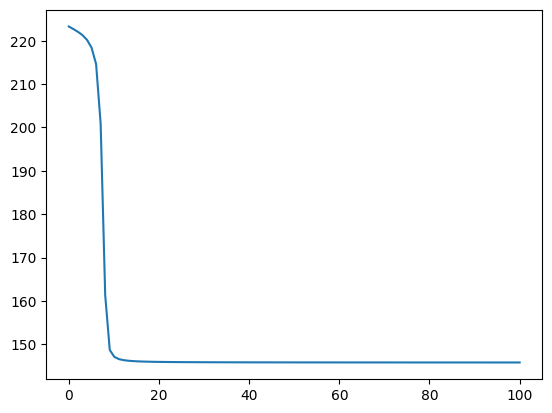

In [41]:
plt.plot(np.linspace(0, epochs, epochs), track_cost)
plt.show()

In [42]:
## Initialize objects for counting correct/total 
correct = 0
total = 0

### Convert data frame to Tensor for DataLoader
y_test_tensor = torch.Tensor(test_y)
X_test_tensor = torch.from_numpy(test_X)
X_test_tensor = torch.movedim(X_test_tensor, source=3, destination=1)
test_loader = DataLoader(TensorDataset(X_test_tensor.type(torch.FloatTensor), 
                        y_test_tensor.type(torch.LongTensor)), batch_size=bsize)

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(correct/total)

1.0
